In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ImageClassificationCNN(nn.Module):
    def __init__(self):
        super(ImageClassificationCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(128 * 31 * 31, 512)
        self.fc2 = nn.Linear(512, 5)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []
        self.category_to_idx = {
            'bridge': 0,
            'streetlight': 1,
            'lake_water': 2,
            'kapok': 3,
            'green_leaves': 4
        }

        # Load all images from subdirectories
        for category in self.category_to_idx.keys():
            category_path = os.path.join(base_dir, category)
            if not os.path.exists(category_path):
                print(f"Warning: Directory not found - {category_path}")
                continue

            print(f"Loading {category} images from {category_path}")
            category_idx = self.category_to_idx[category]

            for img_name in os.listdir(category_path):
                if img_name.endswith('.jpg'):
                    img_path = os.path.join(category_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(category_idx)

        print(f"Loaded total {len(self.images)} images from {base_dir}")
        for category, idx in self.category_to_idx.items():
            count = self.labels.count(idx)
            print(f"{category}: {count} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, self.labels[idx]
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            # Return a default image or raise the exception
            raise e

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    best_accuracy = 0.0
    train_losses = []
    train_accuracies = []

    print(f"\nTraining started at: {datetime.utcnow()}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if (batch_idx + 1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, '
                      f'Running Acc: {100.0 * correct/total:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100.0 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f'\nEpoch [{epoch+1}/{num_epochs}] Summary:')
        print(f'Average Loss: {epoch_loss:.4f}')
        print(f'Accuracy: {epoch_accuracy:.2f}%')
        print(f'Time: {datetime.utcnow()}\n')

        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': best_accuracy,
            }, 'best_model.pth')
            print(f'New best model saved with accuracy: {best_accuracy:.2f}%\n')

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 5
    class_total = [0] * 5

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Per-class accuracy
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    accuracy = 100.0 * correct / total
    print(f'\nTest Results at {datetime.utcnow()}:')
    print(f'Overall Accuracy: {accuracy:.2f}%')

    # Print per-class accuracy
    categories = ['bridge', 'streetlight', 'lake_water', 'kapok', 'green_leaves']
    for i in range(5):
        class_acc = 100.0 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f'{categories[i]}: {class_acc:.2f}% ({class_correct[i]}/{class_total[i]})')

    return accuracy


In [ ]:
if __name__ == "__main__":
    torch.manual_seed(42)

    train_transform = transforms.Compose([
        transforms.Resize((250, 250)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((250, 250)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    batch_size = 32
    learning_rate = 0.001
    num_epochs = 50

    train_dataset = CustomImageDataset(
        base_dir='/content/pictures/train',
        transform=train_transform
    )

    test_dataset = CustomImageDataset(
        base_dir='/content/pictures/test',
        transform=test_transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4
    )

    model = ImageClassificationCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting training...")
    train_model(model, train_loader, criterion, optimizer, num_epochs)

    print("\nLoading best model for evaluation...")
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"Best model was saved at epoch {checkpoint['epoch']+1} "
          f"with accuracy {checkpoint['accuracy']:.2f}%")

    final_accuracy = evaluate_model(model, test_loader)

Loading bridge images from /content/pictures/train/bridge
Loading streetlight images from /content/pictures/train/streetlight
Loading lake_water images from /content/pictures/train/lake_water
Loading kapok images from /content/pictures/train/kapok
Loading green_leaves images from /content/pictures/train/green_leaves
Loaded total 50 images from /content/pictures/train
bridge: 10 images
streetlight: 10 images
lake_water: 10 images
kapok: 10 images
green_leaves: 10 images
Loading bridge images from /content/pictures/test/bridge
Loading streetlight images from /content/pictures/test/streetlight
Loading lake_water images from /content/pictures/test/lake_water
Loading kapok images from /content/pictures/test/kapok
Loading green_leaves images from /content/pictures/test/green_leaves
Loaded total 25 images from /content/pictures/test
bridge: 5 images
streetlight: 5 images
lake_water: 5 images
kapok: 5 images
green_leaves: 5 images
Starting training...

Training started at: 2024-11-29 19:20:48.

<ipython-input-70-23298f07f668>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


Best model was saved at epoch 12 with accuracy 100.00%

Test Results at 2024-11-29 19:25:12.249336:
Overall Accuracy: 96.00%
bridge: 100.00% (5/5)
streetlight: 100.00% (5/5)
lake_water: 100.00% (5/5)
kapok: 80.00% (4/5)
green_leaves: 100.00% (5/5)


In [ ]:
def predict_image(model, image_path, transform, class_names):
    """Predict the class of a single image and display it."""
    try:
        image = Image.open(image_path).convert('RGB')
        if transform:
            image_tensor = transform(image).unsqueeze(0).to(device)
        else:
            print("No transform provided.")
            return None

        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            _, predicted = outputs.max(1)
        predicted_class = class_names[predicted.item()]

        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted Class: {predicted_class}")
        plt.show()

        print(f"Predicted Class: {predicted_class}")
    except Exception as e:
        print(f"Error predicting image: {str(e)}")

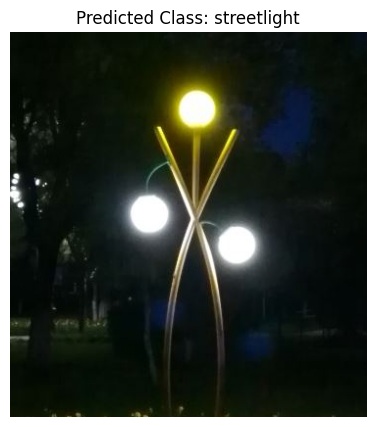

Predicted Class: streetlight


In [ ]:
class_names = ['bridge', 'streetlight', 'lake_water', 'kapok', 'green_leaves']
test_image_path = '/content/test.jpg'
predict_image(model, test_image_path, test_transform, class_names)